In [1]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(1)
# base station location
base_X = 25
base_Y = -100
# transmission energy and receive energy J/bit
ETx = 50*0.000000001
ERc = ETx
# amplification coefficientds J/bit/m^2
epsilon_amp = 10*0.000000000001
# number of clusters
num_clusters = 5
# number of nodes
num_nodes = 100
# initial energy of one node
energy = 2
# size of a packet
packet_bit = 20000
# aggregation energy
aggr = 5*0.000000001
# gather x bits together and aggregate them into 0.3 * x bits
aggr_rate = 0.25
# P and 1/P calculating threshould
P = num_clusters / (num_nodes * 1.0)
one_by_P = num_nodes // num_clusters

In [3]:
# cluster class
class Cluster:
    def __init__(self):
        # nodes in one cluster
        self.nodes = []
        # cluster head, type (node)
        self.head = None
        # number of bits awaiting aggregation
        self.bits = 0
    
    # add one node into the cluster
    def add(self, node):
        self.nodes.append(node)
      
    # tell whether the node is the cluster head
    def is_head(self, node):
        return node == self.head
    
    # quick calculation of the square of distance between one node and the cluster head
    def dis(self, node):
        return distance(node.X, self.head.X, node.Y, self.head.Y)

In [4]:
# square of distance instead of distance
def distance(x_1, x_2, y_1, y_2):
    return (x_1 - x_2)**2 + (y_1 - y_2)**2

In [5]:
def T(r):
    #print(P, one_by_P, r, P / (1 - P * (r % one_by_P)))
    return P / (1 - P * (r % one_by_P))

In [17]:
import random

class Node:
    def __init__(self, x, y):
        # (X,Y)
        self.X = x
        self.Y = y
        # remaining energy
        self.energy = energy
        # false means the nodes alive, otherwise dead
        self.die = False
        self.last = -1
        self.cluster = None
    
    def elect(self, r, clusters):
        self.cluster = None
        if r % one_by_P == 0:
            self.last = -1
        if (self.last == -1 or self.last + one_by_P <= r % one_by_P) and not self.die:
            if random.uniform (0,1) <= T(r):
                cluster = Cluster()
                cluster.add(self)
                cluster.head = self
                clusters.append(cluster)
                self.last = r
                self.cluster = cluster
                #print(r, len(clusters))
    
    def select(self, r, clusters):
        if self.cluster != None:
            return
        min_dis = 100000000
        cluster = -1
        for i in range(len(clusters)):
            if min_dis > clusters[i].dis(self):
                cluster = i
                min_dis = clusters[i].dis(self)
        #print(len(clusters), cluster)
        if cluster == -1:
            return
        clusters[cluster].add(self)
        self.cluster = clusters[cluster]
    
    def direct(self):
        transmission = ETx * packet_bit
        amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
        if self.energy < transmission + amplification:
            self.die = True
        else:
            self.energy -= (transmission + amplification)
    
    def send(self):
        if self.cluster.is_head(self):
            if self.cluster.bits == 0:
                transmission = ETx * packet_bit
                amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification)
            else:
                transmission = ETx * aggr_rate * (packet_bit + self.cluster.bits)
                amplification = epsilon_amp * aggr_rate * (packet_bit + self.cluster.bits) * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification + aggr:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification + aggr)
                self.cluster.bits = 0
        else:
            if self.cluster.head.die:
                self.die = True
                return
            transmission = ETx * packet_bit
            amplification = epsilon_amp * packet_bit * self.cluster.dis(self)
            if self.energy < transmission + amplification:
                self.die = True
            else:
                self.energy -= (transmission + amplification)
            receive = ERc * packet_bit
            self.cluster.head.energy -= receive
            self.cluster.bits += packet_bit

In [7]:
num_nodes = 200
Xs = uniform.rvs(loc=0, scale=60, size=num_nodes)
Ys = uniform.rvs(loc=0, scale=60, size=num_nodes)

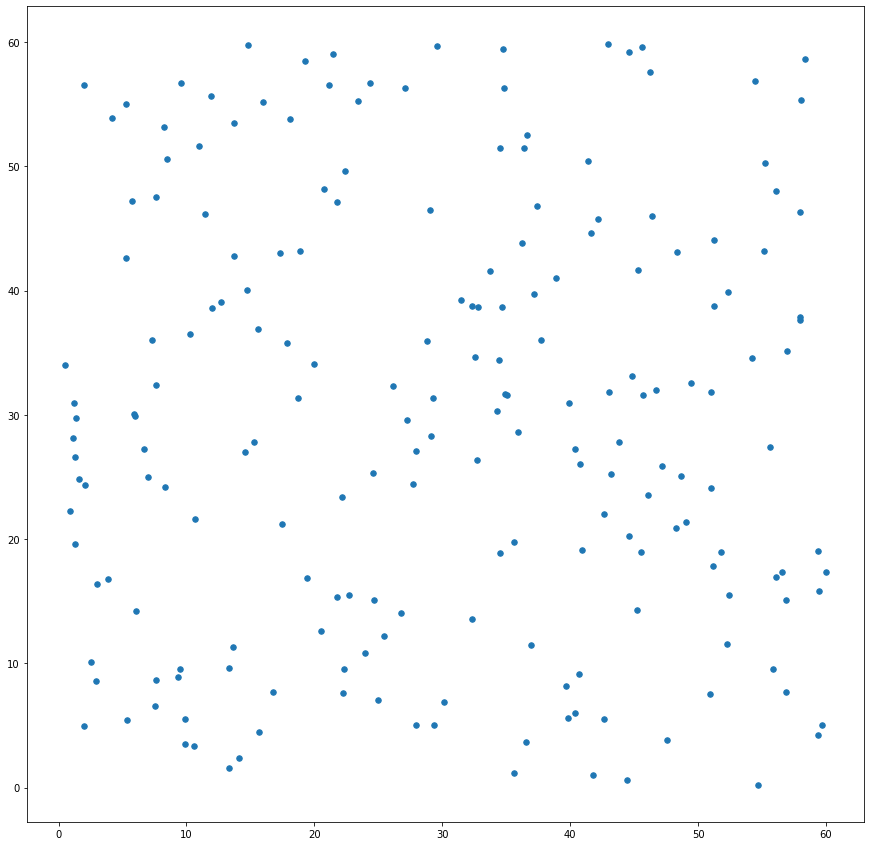

In [8]:
plt.figure(figsize=(15, 15))
plt.scatter(Xs, Ys, s = 30)

In [9]:
# 2 ---> 4
# 1 ---> 4
# 0.5 ---> 4
# 0.25 ---> 2
# 0.125 ---> 2
# 4 ----> 4

0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 1
1600 number of nodes dead 97
2000 number of nodes dead 186
2400 number of nodes dead 200


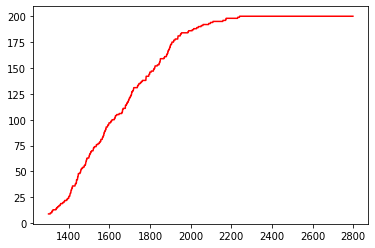

In [9]:
packet_bit = 2000
energy = 0.5
num_rounds = 2800
random.seed(1)
color = ['red', 'blue', 'green', 'yellow', 'purple']
index = -1
for k in [1]:
    index += 1
    Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
    clusters = []
    dead = []
    num = []
    P = 0.05
    one_by_P = 1/P
    for i in range(num_rounds):
        if i%400 == 0:
            print(i, "number of nodes dead", len(dead))
        num.append(len(dead))
        #print("energy", Nodes[0].energy)
        clusters = []
        for node in Nodes:
            node.elect(i, clusters)
        if len(clusters) == 0:
            #print(i, "PPPPPPPPPP", P, T(i))
            #P = 5/(num_nodes - len(dead) + 1)
            P *= k
            P = min(1, P)
            one_by_P = 1/P
            for j in range(num_nodes):
                if j not in dead:
                    Nodes[j].direct()
                    if Nodes[j].die:
                        dead.append(j)
        else:
            for node in Nodes:
                node.select(i, clusters)
            for j in range(num_nodes):
                if j not in dead and not Nodes[j].cluster.is_head(Nodes[j]):
                    Nodes[j].send()
                    if Nodes[j].die:
                        dead.append(j)
            for j in range(num_nodes):
                if j not in dead and Nodes[j].cluster.is_head(Nodes[j]):
                    Nodes[j].send()
                    if Nodes[j].die:
                        dead.append(j)

    plt.plot(range(num_rounds)[1300:], num[1300:], color = color[index])

In [50]:
packet_bit = 2000
energy = 0.5
num_rounds = 2800
random.seed(1)
color = ['red', 'blue', 'green', 'yellow', 'purple']
index = -1
for k in [1]:
    index += 1
    Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
    clusters = []
    num = []
    live = [i for i in range(num_nodes)]
    P = 0.05
    one_by_P = 1/P
    for i in range(num_rounds):
        clusters = [Cluster() for i in range(num_clusters)]
        for j in range(num_clusters):
            if len(live) == 0:
                break
            clusters[j].head = Nodes[live[(i*num_clusters + j) % len(live)]]
            print(Nodes[live[(i*num_clusters + j) % len(live)]].energy, i, live[(i*num_clusters + j) % len(live)])
        for node in Nodes:
            node.select(i, clusters)
        for j in range(num_nodes):
            if not Nodes[j].die and not Nodes[j].cluster.is_head(Nodes[j]):
                Nodes[j].send()
                #print(Nodes[j].cluster.bits)
        for j in range(num_clusters):
            if not clusters[j].head.die:
                #print(clusters[j].bits)
                clusters[j].head.send()      
        for j in range(num_nodes):
            if j in live and Nodes[j].die:
                live.remove(j)
        if i%10 == 0:
            print(i, "number of nodes live", len(live))
        num.append(len(live))

    plt.plot(range(num_rounds), num, color = color[index])

0.5 0 0
0.5 0 1
0.5 0 2
0.5 0 3
0.5 0 4
0 number of nodes live 200
0.4998984971556963 1 5
0.49988988073289214 1 6
0.4998973062345849 1 7
0.49989327896482727 1 8
0.4998999736288405 1 9
0.49978651500134363 2 10
0.4997971336928734 2 11
0.4997904454930088 2 12
0.4997928428268654 2 13
0.499798888740587 2 14
0.49969285741347963 3 15
0.4996810872037774 3 16
0.4996721738346969 3 17
0.49966349706678825 3 18
0.4996667597998275 3 19
0.4995785039825249 4 20
0.4995860831203556 4 21
0.49959474576485463 4 22
0.49956899401835564 4 23
0.4995944841707729 4 24
0.4994363747304596 5 25
0.49949647122007595 5 26
0.49948313882463136 5 27
0.49946462858013807 5 28
0.49949552500270317 5 29
0.4993641337823169 6 30
0.499396464252047 6 31
0.4993638872449244 6 32
0.49937498023408333 6 33
0.49939594299457446 6 34
0.4992664654402582 7 35
0.4992362757793547 7 36
0.49928807712431345 7 37
0.4991783928213615 7 38
0.49929728711340005 7 39
0.4991619309178281 8 40
0.4991947223662825 8 41
0.49919783338633206 8 42
0.4990880693

0.4928040401946999 68 126
0.49271695838972684 68 130
0.49237280430379016 68 131
0.49270309004538754 69 133
0.4927887022093196 69 134
0.4928604087493716 69 135
0.49229441240825605 69 136
0.4925428697353773 69 137
0.49265211378699325 70 138
0.49270146896664446 70 139
0.49241925391784225 70 143
0.4920731664322924 70 146
0.49266082676983247 70 148
70 number of nodes live 129
0.49169887869207135 71 150
0.4922873181843433 71 151
0.4926815094236002 71 152
0.4926425633868096 71 154
0.4924020489747238 71 156
0.49244827421856874 72 158
0.4919237609842667 72 161
0.4925246127842563 72 162
0.4924454664935387 72 163
0.4925239516301533 72 164
0.4923597288922633 73 165
0.4921400061760793 73 167
0.4924839729831372 73 168
0.49242036988381654 73 170
0.4917356652777367 73 172
0.4923710318503407 74 173
0.4920093609690479 74 174
0.4915296379698073 74 177
0.49222394004423364 74 178
0.4920560234638778 74 180
0.4915937262284388 75 182
0.49198612168759465 75 183
0.49215869396963324 75 184
0.4917710794777222 75 

AttributeError: 'NoneType' object has no attribute 'die'

0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 48
2000 number of nodes dead 163
2400 number of nodes dead 197


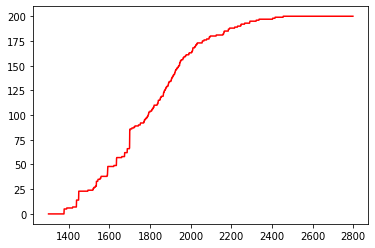

In [35]:
Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
clusters = []
dead = []
num = []
P = 0.05
one_by_P = 1/P
for i in range(num_rounds):
    if i%400 == 0:
        print(i, "number of nodes dead", len(dead))
    num.append(len(dead))
    #print("energy", Nodes[0].energy)
    clusters = []
    for node in Nodes:
        node.elect(i, clusters)
    if len(clusters) == 0:
        P *= (1 + max((len(dead) - 0.3 * num_nodes), 0) / num_nodes)
        #P = 5 / ((num_nodes) - len(dead) + 1)
        P = min(1, P)
        one_by_P = 1/P
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].direct()
                if Nodes[j].die:
                    dead.append(j)
    else:
        for node in Nodes:
            node.select(i, clusters)
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].send()
                if Nodes[j].die:
                    dead.append(j)

plt.plot(range(num_rounds)[1300:], num[1300:], color = "red")

In [31]:
random.seed(1)
Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
clusters = []
dead = []
num1 = []
P = 0.05
one_by_P = 1/P
for i in range(num_rounds):
    if i%400 == 0:
        print(i, "number of nodes dead", len(dead))
    num1.append(len(dead))
    #print("energy", Nodes[0].energy)
    clusters = []
    for node in Nodes:
        node.elect(i, clusters)
    if len(clusters) == 0:
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].direct()
                if Nodes[j].die:
                    dead.append(j)
    else:
        for node in Nodes:
            node.select(i, clusters)
        for j in range(num_nodes):
            if j not in dead:
                Nodes[j].send()
                if Nodes[j].die:
                    dead.append(j)


0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 0
1600 number of nodes dead 47
2000 number of nodes dead 173
2400 number of nodes dead 199


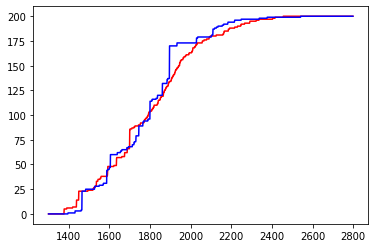

In [36]:
plt.plot(range(num_rounds)[1300:], num[1300:], color = "red")
plt.plot(range(num_rounds)[1300:], num1[1300:], color = "blue")

0 number of nodes dead 0
10 number of nodes dead 0
20 number of nodes dead 0
30 number of nodes dead 0
40 number of nodes dead 0
50 number of nodes dead 0
60 number of nodes dead 0
70 number of nodes dead 0
80 number of nodes dead 0
90 number of nodes dead 0
100 number of nodes dead 24
110 number of nodes dead 42
120 number of nodes dead 57
130 number of nodes dead 70
140 number of nodes dead 79
150 number of nodes dead 84
160 number of nodes dead 97
170 number of nodes dead 100
180 number of nodes dead 100
190 number of nodes dead 100
200 number of nodes dead 100
210 number of nodes dead 100
220 number of nodes dead 100
230 number of nodes dead 100
240 number of nodes dead 100


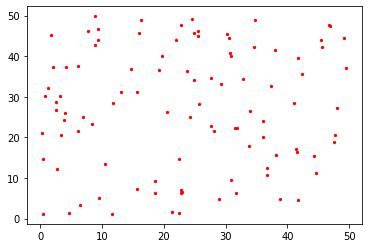

In [13]:
Nodes = [None for i in range(num_nodes)]

for i in range(num_nodes):
    Nodes[i] = Node(Xs[i], Ys[i])
num2 = []
dead = []
for i in range(250):
    num2.append(len(dead))
    if i%10 == 0:
        print(i, "number of nodes dead", len(dead))
    #print(Nodes[0].energy)
    for j in range(num_nodes):
        if j not in dead:
            Nodes[j].direct()
            if Nodes[j].die:
                dead.append(j)
                
dead_X = []
dead_Y = []
undead_X = []
undead_Y = []
for i in range(num_nodes):
    if i in dead:
        dead_X.append(Xs[i])
        dead_Y.append(Ys[i])
    else:
        undead_X.append(Xs[i])
        undead_Y.append(Ys[i])
plt.scatter(dead_X, dead_Y, s = 5, color = 'red')
plt.scatter(undead_X, undead_Y, s = 5, color = 'blue')

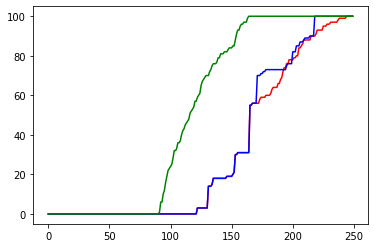

In [34]:
plt.plot(range(250), num, color = 'r')
plt.plot(range(250), num1, color = 'b')
plt.plot(range(250), num2, color = 'g')